# Imports

In [16]:
import torch
import numpy as np
from torch import autograd
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
import pandas as pd
import math
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

# Global Variables

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Helper Functions

In [46]:
def get_density_chart(P, d=7.0, step=0.1, dist_type=None):
    """
    Given a probability distribution, return a density chart (Heatmap)
    Inputs:
        P: Probability distribution
        d: A value used to bound the meshgrid
        step: A value used in the arange method to create the meshgrid
    Outputs:
        chart: Altair object corresponding to a density plot
    """
    xv, yv = torch.meshgrid([torch.arange(-d, d, step), torch.arange(-d, d, step)])
    pos_xy = torch.cat((xv.unsqueeze(-1), yv.unsqueeze(-1)), dim=-1)
    p_xy = P.log_prob(pos_xy.to(device)).exp().unsqueeze(-1).cpu()


    df = torch.cat([pos_xy, p_xy], dim=-1).numpy()
    df = pd.DataFrame({
        'x': df[:, :, 0].ravel(),
        'y': df[:, :, 1].ravel(),
        'p': df[:, :, 2].ravel(),})

    chart = alt.Chart(df).mark_point().encode(

        x=alt.X('x:Q', axis=alt.Axis(title='', labelFontSize=20, tickSize=12)),
        y=alt.Y('y:Q', axis=alt.Axis(title='', labelFontSize=20, tickSize=12)),
        color=alt.Color('p:Q', scale=alt.Scale(scheme='lightorange')),
        tooltip=['x','y','p']).properties(
        width=220,
        height=190
    )


    return chart



def get_particles_chart(X, masked = None, X_svgd=None):
    """
    Given a set of points, return a scatter plot
    Inputs:
        X: Final positions of the particles after applying svgd
        X_svgd: Intermidiate position of the particles while applying svgd. If None do not add them to the plot
    Outputs:
        chart: Altair object corresponding to a scatter plot
    """
    df = pd.DataFrame({
        'x': X[:, 0],
        'y': X[:, 1],})

    chart = alt.Chart(df).mark_circle(color='black').encode(x='x:Q',y='y:Q')

    if masked is not None:
      df_masked =pd.DataFrame({
        'x': masked[:, 0],
        'y': masked[:, 1],})
      chart += alt.Chart(df_masked).mark_circle(shape = 'cross', color = 'red').encode(x='x:Q',y='y:Q')

    if X_svgd is not None:
        for i in range(np.shape(X_svgd)[1]):
            df_trajectory = pd.DataFrame({'x': X_svgd[:,i,0],'y': X_svgd[:,i,1],})
            chart += alt.Chart(df_trajectory).mark_line().mark_circle(color='green').encode(x='x:Q',y='y:Q')

    return chart


def filter(results, constraints):
    """
    Given a dictionary of experiments results, search it given a list of constraints
    Inputs:
        results: A dictionary of experimental results
        constraints: A list of configuration constraints
    Outputs:
        Elements based on the input configurations of experiments
    """
    configs = []
    for i in range(len(results['configs'])):
        check_bool = True
        for j in range(len(results['configs'][i])):
            if constraints[j] == '*':
                continue
            if results['configs'][i][j] != constraints[j]:
                check_bool = False
                break
        if check_bool:
            configs.append(i)

    return np.array(results['sampler_entr_svgd'])[configs].tolist(), np.array(results['gt_entr'])[configs].tolist(), np.array(results['charts_svgd'])[configs].tolist(), np.array(results['init_chart'])[configs].tolist()

def figure_4c(results, mu, sigma, figure_name='figure_4c'):
    """
    Create figure 4c in the paper
    Inputs:
        results: Dictionary containing all the saved data
        mu: Mean of the initial distribution
        sigma: Standard deviation of the initial distribution
        figure_name: Figure name
    """

    x_values = ['0.1', '1', '3', '5', '7', '10', '100']
    entropies, gt_entr, charts, init_charts = filter(results, ['*', '*', '*', '*', 200, 200, '*' , mu, sigma])
    dis_200s_200p = entropies
    entropies, gt_entr, charts, init_charts = filter(results, ['*', '*', '*', '*', 100, 100, '*' , mu, sigma])
    dis_100s_100p = entropies
    entropies, gt_entr, charts, init_charts = filter(results, ['*', '*', '*', '*', 10, 20, '*' , mu, sigma])
    dis_20s_10p = entropies
    entropies, gt_entr, charts, init_charts = filter(results, ['*', '*', '*', '*', 20, 20, '*' , mu, sigma])
    dis_20s_20p = entropies

    plt.rcParams.update({'font.size': 18})
    fig = plt.figure(figsize=(8, 5))
    plt.scatter(x_values, dis_200s_200p, marker="o", label="200", s=60 )
    plt.scatter(x_values, dis_100s_100p, marker="s", label="100", s=60 )
    plt.scatter(x_values, dis_20s_20p, marker="P", label="20", s=60 )
    plt.scatter(x_values, dis_20s_10p, marker="*", label="10", s=60 )
    plt.axhline(y = np.mean(gt_entr), color = 'g', linestyle = 'dotted')
    plt.legend(title="# particles", loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("Kernel variance")
    plt.ylabel(r"$H(q^L)$")
    plt.ylim(0, 5)
    plt.savefig('./' + figure_name + '.pdf', bbox_inches='tight')
    plt.show()

def figure_4b(results, dims, expr_name, x_label, x_ticks, results_tmp=None, results_200=None, resutls_500=None):
    """
    Create figure 4b from the paper
    Inputs:
        results: Dictionary containing all the results' data
        dims: A list containing the dimensions we want to print
        expr_name: Experiment name
        x_label: X axis label
        x_ticks: X axis ticks
    """

    for dim in dims:
        filtered_results = [filter(results[i][expr_name], [dim, '*', '*', '*', 10, 20, '*' , 0, 6]) for i in range(len(results))]
        gmm1_20s_10p = [filtered_results[i][0] for i in range(len(filtered_results))]

        if results_tmp == None:
            filtered_results = [filter(results[i][expr_name], [dim, '*', '*', '*', 10, 10, '*' , 0, 6]) for i in range(len(results))]
        else:
            filtered_results = [filter(results_tmp[i][expr_name], [dim, '*', '*', '*', 10, 10, '*' , 0, 6]) for i in range(len(results_tmp))]
        gmm1_10s_10p = [filtered_results[i][0] for i in range(len(filtered_results))]
        if results_200 == None:
            filtered_results = [filter(results[i][expr_name], [dim, '*', '*', '*', 200, 200, '*' , 0, 6]) for i in range(len(results))]
        else:
            filtered_results = [filter(results_200[i][expr_name], [dim, '*', '*', '*', 200, 200, '*' , 0, 6]) for i in range(len(results_200))]
        gmm1_200s_200p = [filtered_results[i][0] for i in range(len(filtered_results))]

        if results_500 == None:
            filtered_results = [filter(results[i][expr_name], [dim, '*', '*', '*', 200, 500, '*' , 0, 6]) for i in range(len(results))]
        else:
            filtered_results = [filter(resutls_500[i][expr_name], [dim, '*', '*', '*', 200, 200, '*' , 0, 6]) for i in range(len(resutls_500))]
        gmm1_500s_200p = [filtered_results[i][0] for i in range(len(filtered_results))]


        raw_mean = [list(np.nanmean(gmm1_20s_10p, axis=0)), list(np.nanmean(gmm1_10s_10p, axis=0)), list(np.nanmean(gmm1_200s_200p, axis=0)), list(np.nanmean(gmm1_500s_200p, axis=0))]
        raw_std = [list(np.nanstd(gmm1_20s_10p, axis=0)), list(np.nanstd(gmm1_10s_10p, axis=0)), list(np.nanstd(gmm1_200s_200p, axis=0)), list(np.nanstd(gmm1_500s_200p, axis=0))]
        colors = ['r', 'g', 'b', 'k']
        labels = ['#(p,s): (10,20) ', '#(p,s): (10,10) ', '#(p,s): (200,200) ', '#(p,s): (200,500) ']
        plt.figure(figsize=(8, 6), dpi=150)
        plt.xlabel(x_label)
        plt.ylabel("Entropy")
        for i in range(len(raw_mean)):
            plt.errorbar(np.array([0.0, 1.0, 2.0, 3.0]), raw_mean[i], yerr=raw_std[i], color=colors[i], marker='o', label=labels[i])
        plt.xticks(np.array([0.0, 1.0, 2.0, 3.0]), np.array(x_ticks))
        plt.xlim([-0.5, 3.5])
        plt.title('dim_' + str(dim))
        plt.legend()
        plt.savefig('./' + expr_name + '_' + str(dim) + '.png', bbox_inches='tight')

def stID_chart(x):
    df = pd.DataFrame({
      'step': range(len(x)),
      'stein identity': x,})

    chart = alt.Chart(df).mark_line().encode(x='step:Q',y='stein identity:Q')
    return chart

# def entropies_chart(ents, gt_ent):
#   ent1, ent2 = ents[0], ents[1]
#   df = pd.DataFrame({
#       'svgd_step':range(len(ent1)),
#       'entropy1':ent1,
#       'entropy2':ent2})
#   ## gt entropy
#   plt.axhline(y = gt_entr, color='r', linestyle='-', label = 'gt_entropy')
#   # line 1
#   plt.plot(df['svgd_step'], df['entropy1'], label = 'line 1', color = '#006400')
#   #line 2
#   plt.plot(df['svgd_step'], df['entropy2'], label = 'line 2', color = '#00CED1')
#   # add extra axis for the stein id
#   # plt.plot(stein_id_0['svgd_step'], stein_id_0['stein identity'], color= '#0000FF')
#   plt.legend()

#   plt.xlabel('itr')
#   plt.ylabel('entropies')

  # plt.show()



# Kernel

In [ ]:
class RBF:
    """
    Radial basis funtion kernel (https://en.wikipedia.org/wiki/Radial_basis_function)
    Inputs:
        sigma: Kernel standard deviation
        num_particles: Number of particles
    """
    def __init__(self, sigma, num_particles):
        self.sigma = sigma
        self.num_particles = num_particles

    def forward(self, input_1, input_2):
        """
        Given two tensors of particles, return the matrix of distances between each particle
        Inputs:
            input_1: Particles coordinates
            input_2: Particles coordinates
        Outputs:
            kappa: RBF matrix
            diff: Signed distance
            h: Kernel variance
            kappa_grad: Derivative of rbf kernel
            gamma: 1/2*sigma**2
        """
        # Check if the inputs have the same size in the last two dimensions
        assert input_2.size()[-2:] == input_1.size()[-2:]

        # Compute the difference between each particle
        diff = input_1.unsqueeze(-2) - input_2.unsqueeze(-3)
        # Square the difference and sum over the particle's dimensions
        dist_sq = diff.pow(2).sum(-1)
        dist_sq = dist_sq.unsqueeze(-1)

        if self.sigma == "mean":
            # Estimate the kernel variance using the mean of all the particles distances
            median_sq = torch.mean(dist_sq.detach().reshape(-1, self.num_particles*self.num_particles), dim=1)
            median_sq = median_sq.unsqueeze(1).unsqueeze(1)
            h = median_sq / (2 * np.log(self.num_particles + 1.))
            sigma = torch.sqrt(h)
        elif self.sigma == "forth":
            # Estimate the kernel variance using the mean devided by two (one forth) of all the particles distances
            median_sq = 0.5 * torch.mean(dist_sq.detach().reshape(-1, self.num_particles*self.num_particles), dim=1)
            median_sq = median_sq.unsqueeze(1).unsqueeze(1)
            h = median_sq / (2 * np.log(self.num_particles + 1.))
            sigma = torch.sqrt(h)
        elif self.sigma == "median":
            # Estimate the kernel variance using the median of all the particles distances
            median_sq = torch.median(dist_sq.detach().reshape(-1, self.num_particles*self.num_particles), dim=1)[0]
            median_sq = median_sq.unsqueeze(1).unsqueeze(1)
            h = median_sq / (2 * np.log(self.num_particles + 1.))
            sigma = torch.sqrt(h)
        else:
            # Setting the kernel variance from the input
            sigma = self.sigma
            h = None

        gamma = 1.0 / (1e-8 + 2 * sigma**2)

        kappa = (-gamma * dist_sq).exp()
        # Computing the gradient of the kernel over the particles
        kappa_grad = -2. * (diff * gamma) * kappa
        return kappa.squeeze(), diff, h, kappa_grad, gamma

# GMM

In [ ]:

class GMMDist(object):
    """
    Gaussian Mixture Model
    Inputs:
        dim: Number of dimensions of the random variable
        n_gmm: Number of mixtures
        sigma: Mixutures' standard diviation
    """
    def __init__(self, dim, n_gmm, sigma):
        def _compute_mu(i):
            """
            Compute the mean of each mixture
            Inputs:
                i: Index of the mixture
            Outputs:
                The mean of each dimension of the random variable
            """
            return 4 * torch.Tensor([[torch.tensor(i * math.pi / (n_gmm/2)).sin(),torch.tensor(i * math.pi / (n_gmm/2)).cos()] + [torch.rand((1,)) * 2 - 1 for _ in range(dim - 2)]])

        # Generate a list of equal probabilities between the mixtures
        self.mix_probs = (1.0/n_gmm) * torch.ones(n_gmm).to(device)
        # Compute the means
        self.means = torch.cat([_compute_mu(i) for i in range(n_gmm)], dim=0).to(device)
        # Compute the standard deviations
        self.sigma = sigma
        self.std = torch.stack([torch.ones(dim).to(device) * self.sigma for i in range(len(self.mix_probs))], dim=0)


    def sample(self, n):
        """
        Sample a tensor of particles
        Inputs:
            n: Number of particles
        Outputs:
            A tensor of particles that follows this distribution
        """
        mix_idx = torch.multinomial(self.mix_probs, n[0], replacement=True)
        means = self.means[mix_idx]
        stds = self.std[mix_idx]
        return torch.randn_like(means) * stds + means

    def log_prob(self, samples):
        """
        Given a tensor of particles, compute their log probability with respect to the current distribution
        (the mixtures are independent)
        Inputs:
            samples: A tensor of particles
        Outputs:
            A tensor of log probabilites
        """
        logps = []
        for i in range(len(self.mix_probs)):
            logps.append((-((samples.to(device) - self.means[i]) ** 2).sum(dim=-1) / (2 * self.sigma ** 2) - 0.5 * np.log(
                2 * np.pi * self.sigma ** 2)) + self.mix_probs[i].log())
        logp = torch.logsumexp(torch.stack(logps, dim=0), dim=0)
        return logp


# Optimizer

In [ ]:

class Optim():
    """
    Optimizer Class
    Inputs:
        lr: Learning rate
    """
    def __init__(self, lr=None):
        self.m_dx, self.v_dx = 0, 0
        self.lr = lr

    def step(self,x, dx):
        """
        Gradient Ascent
        Inputs:
            x: A tensor of particles
            dx: The update vector
        Outputs:
            x: Updated particles
        """
        dx = dx.view(x.size())
        x = x + self.lr * dx
        return x


# Entropy Computation

In [40]:
class Entropy():
    """
    Entropy Class
    Inputs:
        P: GMM Object
        K: RBF Kernel
        optimizer: Gradient Ascent optimizer
        num_particles: Number of particles
        particles_dim: Particles' number of dimensions
    """
    def __init__(self, P, K, optimizer, num_particles, particles_dim):
        self.P = P
        self.optim = optimizer
        self.num_particles = num_particles
        self.particles_dim = particles_dim
        self.K = K

        # Mask parameters
        self.masked_particles = set()
        self.invertibility_threshold = 0.01
        self.invertibility_neighbors = 4


        # Mean of Langevin dynamics initial distribution
        mu_ld_noise = torch.zeros((self.particles_dim,))
        # Standard deviation of Langevin dynamics initial distribution
        sigma_ld_noise = torch.eye(self.particles_dim) * 0.1
        # Langevin dynamics initial distribution
        self.init_dist_ld = torch.distributions.MultivariateNormal(mu_ld_noise,covariance_matrix=sigma_ld_noise)
        # Identity matrix used in the computation of the entropy (line 1)
        self.identity_mat = torch.eye(self.particles_dim).to(device)
        # Identity matrix used in the computation of the entropy (line 3)
        self.identity_mat2 = torch.eye(self.num_particles).to(device)
        # Entropy Variables, Line 1,2 and 3
        self.logp_line1 = 0
        self.logp_line2 = 0
        self.logp_line3 = 0

        # HMC initilization

        self.X_2 = None
        self.V_2 = None

    def SVGD(self,X):
        """
        Compute the Stein Variational Gradient given a set of particles
        Inputs:
            X: A tensor of particles
        Outputs:
            phi: SVGD update rule
            phi_log_prob: SVGD update without considering the distance of the particle to itself
            (used to calculate the log prob)
        """

        # Make X requires grad
        X = X.requires_grad_(True)
        # Compute the log probability  of the particles using the target distribution
        log_prob = self.P.log_prob(X)

        # Compute the gradient of the log probability over the particles
        self.score_func = autograd.grad(log_prob.sum(), X, retain_graph=True, create_graph=True)[0].reshape(self.num_particles, self.particles_dim)
        # Compute the kernel matrices
        self.K_XX, self.K_diff, self.K_h, self.K_grad, self.K_gamma = self.K.forward(X, X)

        #__________INVERTIBILITY EVALUATION________
        #store masked particles in a set
        self.update_masked_points(self.K_XX, self.K_grad)

        # - [ ] update K_grad

        # - [ ] store old mask so that we don't reactivate rows taht were deactivated before.
        curr_particles = (self.num_particles - len(self.masked_particles))

        # Compute the first term of the  SVGD update
        self.phi_term1 = self.K_XX.matmul(self.score_func) / (curr_particles) #self.num_particles
        # Compute the second term of the  SVGD update
        self.phi_term2 = self.K_grad.sum(0) / (curr_particles)  #self.num_particles
        # Compute the SVGD update == h(x)
        phi = self.phi_term1 + self.phi_term2

        # Compute SVGD update without considering the distance of the particle to itself
        #-self.identity_mat2 removes the particles itself
        #__________ invertibility
        phi_log_prob = (self.K_XX-self.identity_mat2).matmul(self.score_func) / (curr_particles -1)
        phi_log_prob += (self.K_grad.sum(0) / (curr_particles -1))

        for i in self.masked_particles:
          #unset in phi and phi_log_prob
          phi[i] = phi_log_prob[i] = torch.zeros(self.particles_dim).to(device)


        return phi, phi_log_prob #h(x), sum(over L steps )



    def compute_logprob(self, phi, X):
        """
        Compute the log probability of the given particles in 3 ways
        Inputs:
            X: A tensor of particles
            phi: Update rule
        Outputs:
            self.logp_line1: Log probability using line 1 in the paper
            self.logp_line2: Log probability using line 2 in the paper
        """
        #__________code 2____________
        '''

    ###_____
        line4_term1 = (self.K_grad * self.score_func.unsqueeze(0)).sum(-1).sum(1)/(self.num_particles)
        line4_term2 = -2 * self.K_gamma * (( self.K_grad.permute(1,0,2) * self.K_diff).sum(-1) - self.particles_dim * (self.K_XX - self.identity_mat2) ).sum(0)/(self.num_particles)
        line4_term3 =  term3/(self.num_particles)
        self.logp_line4 = self.logp_line4 - self.optim.lr * (line4_term1 + line4_term2+ line4_term3)

        '''
        # Compute the derivative of the update rule over each particle separately

        grad_phi =[]
        for i in range(len(X)):
            grad_phi_tmp = []
            for j in range(self.particles_dim):
                if i in self.masked_particles or j in self.masked_particles:
                  grad_ = torch.zeros(self.particles_dim).to(device)
                  grad_phi_tmp.append(grad_)
                else:
                  grad_ = autograd.grad(phi[i][j], X, retain_graph=True)[0][i].detach()
                  grad_phi_tmp.append(grad_)

            grad_phi.append(torch.stack(grad_phi_tmp))

        # self.grad_phi = torch.stack([t.to(device) for t in grad_phi])
        self.grad_phi = torch.stack(grad_phi)
        # Compute the log probability (Line 1) #line1
        self.logp_line1 = self.logp_line1 - torch.log(torch.abs(torch.det(self.identity_mat + self.optim.lr * self.grad_phi)))
        # Compute the log probability (Line 2)
        grad_phi_trace = torch.stack( [torch.trace(grad_phi[i]) for i in range(len(grad_phi))] )
        self.logp_line2 = self.logp_line2 - self.optim.lr * grad_phi_trace
        # Compute the log probability (Line 2)
        #
        # line3_term1 = (self.K_grad * self.score_func.unsqueeze(0)).sum(-1).sum(1)/((self.num_particles - len(self.masked_particles)) -1)
        # line3_term2 = -2 * self.K_gamma * (( self.K_grad.permute(1,0,2) * self.K_diff).sum(-1) - self.particles_dim * (self.K_XX - self.identity_mat2) ).sum(0)/((self.num_particles - len(self.masked_particles)) -1)
        # self.logp_line3 = self.logp_line3 - self.optim.lr * (line3_term1 + line3_term2)


    def step(self, X, V, alg):
        """
        Perform one update step
        Inputs:
            X: A tensor of articles
            alg: The name of the algorithm that should be used
        Outputs:
            X: Updated particles
            phi_X: Update rule
        """
        #_______________code 2___________
        '''
        X_new, violation = self.optim.step(X, phi_X)
        ____________--> added violation  to optim

        if self.with_logprob:
            self.compute_logprob(phi_X_entropy, X, logp_term3)
        ____________--> computed log probability

        convergence = ((X_new-X)**2).sum(-1).mean()
        svgd_converegence = ((phi_X.mean(0))**2).mean(-1)

        if (alg == 'svgd') or (alg == 'ld'):
            X = X_new.detach()
        else:
            X = X_new

        return X, phi_X, violation, convergence, num_componenets, norm_inv_values, svgd_converegence

        '''
        if alg == 'svgd':
            # Compute the SVGD update
            phi_X, phi_X_log_prob = self.SVGD(X)
        # elif alg == 'ld':
        #     # Compute the Langevin Dynamics update
        #     phi_X = self.LD(X, with_noise=True)
        #     phi_X_log_prob = phi_X
        # elif alg == 'dld':
        #     # Compute the Langevin Dynamics update
        #     phi_X = self.LD(X, with_noise=False)
        #     phi_X_log_prob = phi_X
        # elif alg == 'hmc':
        #     # Compute the Hamiltionian Monte-carlo update
        #     phi_X = self.HMC(X, V)
        #     phi_X_log_prob = phi_X

        # Update the particles using the computed update
        X_new = self.optim.step(X, phi_X)
        self.phi_X = phi_X
        # Compute the log probability for the updated particles
        self.compute_logprob(phi_X_log_prob, X)
        # keep track of convergence for stein

        convergence = ((X_new-X)**2).sum(-1).mean()
        svgd_converegence = ((phi_X.mean(0))**2).mean(-1)
        # Detach the particles to prepare for the next iteration
        if alg in ['svgd', 'ld']:
            X = X_new.detach()
        else:
            X = X_new

        return X, phi_X, convergence, svgd_converegence

    def update_masked_points(self, distances):
        """
        check if there is a new masked point
        Inputs:
            X: distance matrix of particles
        """
        mask = (distances > self.invertibility_threshold).int()
        active_neighbors = (mask.sum(-1) > self.invertibility_neighbors).int()

        #modify K_XX and K_grad
        # distances = active_neighbors.unsqueeze(-1) * distances
        # grad = active_neighbors.unsqueeze(-1) * grad

        new_mask = torch.where(active_neighbors == False)[0]

        for i in new_mask:
          self.masked_particles.add(i.item())
          #dynamically update the number of currently active particles





# Experiment

In [ ]:
def my_experiment(dim, n_gmm, num_particles, num_steps, kernel_sigma, gmm_std, lr, mu_init, sigma_init, sigma_V_init, dist_type, run_alg):
    """
    Perform one experiment of running SVGD and computing the entropy
    Inputs:
        dim: Number of dimensions of the particles
        n_gmm: Number of mixutres of the target GMM distribution
        num_particles: Number of particles
        num_step: Number of update steps
        kernel_sigma: Kernel standard diviation
        gmm_std: The target distribution standard diviation
        lr: Learning rate
        sigma_init: Standard deviation of the initial distribution
        mu_init: Mean of the initial distribution
        dist: Type of the target distribution
    Outputs:
        sampler_entr_svgd: The SVGD Entropy
        sampler_entr_ld: The LD Entropy
        gt_entr: The ground truth Entropy
        charts: The list of density plots with particles.(a plot for each svgd step)
    """

    # Creating the initial distribution
    mu = torch.full((dim,), mu_init).to(device).to(torch.float32)
    sigma = (torch.eye(dim) * sigma_init).to(device)
    init_dist = torch.distributions.MultivariateNormal(mu,covariance_matrix=sigma)

    # Sampling a tensor of particles from the initial distribution
    X_init = init_dist.sample((num_particles,)).to(device)

    init_V_dist = torch.distributions.MultivariateNormal(torch.zeros(dim).to(device),covariance_matrix = (torch.eye(dim) * sigma_V_init).to(device))
    V_init = init_V_dist.sample((num_particles,)).to(device)

    if dist_type == 'gmm':
        # Figures 4b, high dimensionality figures
        dist = GMMDist(dim=dim, n_gmm=n_gmm, sigma=gmm_std)
    elif dist_type == 'gauss':
        # Figure 4a
        dist = torch.distributions.MultivariateNormal(torch.Tensor([-0.6871,0.8010]).to(device),covariance_matrix= 5 *torch.Tensor([[0.2260,0.1652],[0.1652,0.6779]]).to(device))

    # Create an entropy experiment object
    experiment = Entropy(dist, RBF(kernel_sigma, num_particles), Optim(lr), num_particles=num_particles, particles_dim=dim)

    # Generate plots only if dim == 2
    if dim == 2:
        gauss_chart = get_density_chart(dist, d=7.0, step=0.1, dist_type=dist_type)
        init_chart = gauss_chart + get_particles_chart(X_init.cpu().numpy())
    else:
        init_chart = None

    # Compute the groud truth entropy
    gt_entr = - dist.log_prob(dist.sample((500,))).mean().cpu().item()

    def main_loop(alg, X, V, steps):
        """
        Perform SVGD updates
        Inputs:
            X: A tensor of particles
            steps: The number of SVGD steps
        Outputs:
            sampler_entr_svgd: The SVGD Entropy
            gt_entr: The ground truth Entropy
            charts: The list of density plots with particles.(a plot for each svgd step)
        """
        # gamma = 1.0 / (1e-8 + 2 * sigma**2)
        active_particles = []
        entropies = []
        convergence_values = []
        charts = []
        X_svgd_=[]
        for t in range(steps):
            # Perform one update step
            X, phi_X, conv, svgd_conv= experiment.step(X, V, alg)
            # Save the intermidiate position of the particles
            X_svgd_.append(X.clone())
            # Generate plots only if dim == 2
            entropy_l_1 =  -(init_dist.log_prob(X_init) + experiment.logp_line1).mean().item()
            entropy_l_2 =  -(init_dist.log_prob(X_init) + experiment.logp_line2).mean().item()


            # how many neighbors per particle for the current sigma
            # neighbor_avg = (((experiment.K_XX > 0.01).int()).sum(-1)).float().mean()
            # active_particles.append(active)
            # sigma_to_neigh[t] = (curr_sig, neighbor_avg.item())

            if dim == 2:
                masked = X.detach().cpu().numpy()[list(experiment.masked_particles),:]
                chart_ = gauss_chart + get_particles_chart(X.detach().cpu().numpy(), masked)
                charts.append(chart_)

            convergence_values.append(svgd_conv)
            entropies.append([entropy_l_1, entropy_l_2])

        X_svgd_ = torch.stack(X_svgd_)
        convergence_values = torch.stack(convergence_values).cpu().detach().numpy()

        # Compute the entropy of the particles using the log probability
        sampler_entr =  -(init_dist.log_prob(X_init) + experiment.logp_line2).mean().item()

        print('################# sampler_entr: ', alg, sampler_entr)
        # print('################# diff X_t X_t-1: ', torch.norm(experiment.phi_X).detach().cpu().numpy())

        # Print line 1 and line 2
        # print(t, ' entropy svgd (line 1): ',  -(init_dist.log_prob(X_init) + experiment.logp_line1).mean().item())
        # print(t, ' entropy svgd (line 2): ',  -(init_dist.log_prob(X_init) + experiment.logp_line2).mean().item())

        return sampler_entr, charts, convergence_values , entropies

    # Print the ground truth entropy
    # print('entropy gt (logp): ', gt_entr)
    # print()

    # Run SVGD
    if run_alg['svgd']:
        # print('___________SVGD___________')
        sampler_entr_svgd, charts_svgd, conv, ent= main_loop('svgd', X_init.clone().detach(), None, steps=num_steps)
    else:
        sampler_entr_svgd, charts_svgd, conv, ent  = None, None, None, None

    # # Run Lengevin Dynamics
    if run_alg['ld']:
        # print('___________LD___________')
        sampler_entr_ld, charts_ld = main_loop('ld', X_init.clone().detach(), None, steps=num_steps[1])
    else:
        sampler_entr_ld, charts_ld = None, None

    # Run Deterministic Lengevin Dynamics
    if run_alg['dld']:
        # print('___________DLD___________')
        sampler_entr_dld, charts_dld = main_loop('dld', X_init.clone().detach(), None, steps=num_steps[1])
    else:
        sampler_entr_dld, charts_dld = None, None

    # Run HMC
    if run_alg['hmc']:
        # print('___________HMC___________')
        sampler_entr_hmc, charts_hmc = main_loop('hmc', X_init.clone().detach(), V_init.clone(), steps=num_steps[2])
    else:
        sampler_entr_hmc, charts_hmc = None, None


    return sampler_entr_svgd, charts_svgd, conv, ent, gt_entr

# Reproduce Paper Figures

### Figure 4a

In [ ]:
# Weather to use the GMM class or not (Figure 4a: gmm == False)
dist_type = 'gauss'
# Dimension of the particles
dim = 2
# Learning Rate
lr = 0.5
# Number of mixtures
n_gmm = 1
# Target distribution's standard deviation, means are computed automatically
gmm_std = 1
# Number of particles
num_particles = 400
# Number of update steps
num_steps = 1000
# Kernel variance
kernel_variance = 'forth'
# Standard deviation of the initial distribution HMC
sigma_V_init = 5
# Dictionary used to select whare algorithms to run
run_alg = {'svgd':True, 'ld':False, 'dld':False, 'hmc':False}



# Mean of the initial distribution
mu_init = 0
# Standard deviation of the initial distribution
sigma_init = 6
# Do one experiment for initial distribution N(0, 6)
# sensitivity_to_para = c.defaultdict(list)
# for kernel_variance in kernel_variances:
#   for lr in lrs:
sampler_entr_svgd, charts_svgd, conv, ent, gt_entr = my_experiment(dim, n_gmm, num_particles, num_steps, kernel_variance, gmm_std, lr, mu_init, sigma_init, sigma_V_init, dist_type, run_alg)
    # sensitivity_to_para[(lr, kernel_variance)] = [gt_entr, ent, conv]

# sampler_entr_svgd, sampler_entr_ld, sampler_entr_hmc, sampler_entr_dld, gt_entr, charts_svgd= my_experiment(dim, n_gmm, num_particles, num_steps, kernel_variance, gmm_std, lr, mu_init, sigma_init, sigma_V_init, dist_type, run_alg)
# print('##############################')

#________________________

# lr = 0.5
# # Number of update steps
# num_steps = [200, 20, 50]
# # Mean of the initial distribution
# mu_init = 4
# # Standard deviation of the initial distribution
# sigma_init = 0.2
# # Do one experiment for initial distribution N(4, 0.2)
# init_chart2, sampler_entr_svgd2, sampler_entr_ld2, sampler_entr_hmc2, sampler_entr_dld2, gt_entr2, charts_svgd2, charts_ld2, charts_hmc2, charts_dld2 = my_experiment(dim, n_gmm, num_particles, num_steps, kernel_variance, gmm_std, lr, mu_init, sigma_init, sigma_V_init, dist_type, run_alg)

# # Concatenate multiple plots together
# alt.vconcat(init_chart | charts_svgd[-1] | charts_dld[-1] | charts_ld[-1] | charts_hmc[-1], init_chart2 | charts_svgd2[-1] | charts_dld2[-1] | charts_ld2[-1] | charts_hmc2[-1])


"""-> run experiment for

- $\sigma_{kernel}$ in `[0.1, 1, 3, 5, 7, 10, 100]`
- for $n_{particles}$ in `[200, 100, 20, 10]`
# """

# #set the variables that remain unchanged
# dist_type = 'gauss'
# dim = 2
# lr = 0.5
# n_gmm = 1
# gmm_std = 1
# num_particles = [200, 100, 20, 10]
# num_steps = [100, 20, 15]
# kernel_variance = [0.1, 1, 3, 5, 7, 10, 100]
# sigma_V_init = 5
# run_alg = {'svgd':True, 'ld':False, 'dld':False, 'hmc':False}


# mu_init = 0
# sigma_init = 6



# sampler_entr_svgd, charts_svgd, conv, ent, gt_entr, sigmas = my_experiment(dim, n_gmm, num_particles, num_steps, kernel_variance, gmm_std, lr, mu_init, sigma_init, sigma_V_init, dist_type, run_alg)



# particles_variance_map

# import matplotlib.pyplot as plt

# for n in num_particles:
#     entropies = [particles_variance_map[(n, v)] for v in kernel_variance]
#     plt.scatter(kernel_variance, entropies, label=f'{n} particles')

# plt.xlabel('Kernel variance σ')
# plt.ylabel('Entropy H(q^L)')
# plt.legend()
# plt.title('Effect of σ on H(q^L) for SVGD')
# plt.xscale('log')
# plt.show()



#### Evaluating the number of lost particles across svgd steps

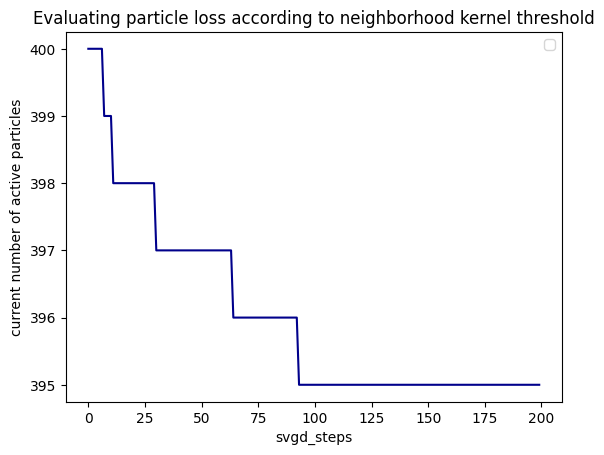

In [ ]:
particles_lost = pd.DataFrame({'svgd_step': np.arange(num_steps), 'particles': act})
plt.plot(particles_lost['svgd_step'], particles_lost['particles'], color= '#00008B')
plt.xlabel('svgd_steps')
plt.ylabel('current number of active particles')
plt.title('Evaluating particle loss according to neighborhood kernel threshold')
plt.legend()

### Qualitative Convergence

In [ ]:
charts_svgd[0]

alt.LayerChart(...)

In [48]:
charts = charts_svgd

In [49]:
qualitative_conv = charts[0].properties(title='init step')
for i in range(25, num_steps, 25):
    qualitative_conv |= charts[i].properties(title=f'step {i}')
qualitative_conv |= charts[-1].properties(title=f'step {num_steps}')
qualitative_conv.save('./' + '.html') #add chart directory


In [50]:
qualitative_conv

alt.HConcatChart(...)

#### <font color=DC143C>Convergence is qualitatively verified!</font>

### Quantitative Convergence



*   Tracking Stein Idendity convergence

*   Tracking Entropy Convergence



In [ ]:
gt_entr

3.3789894580841064

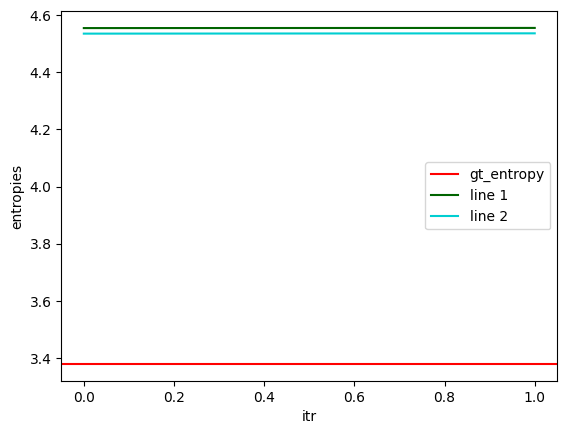

In [ ]:
entropies[]

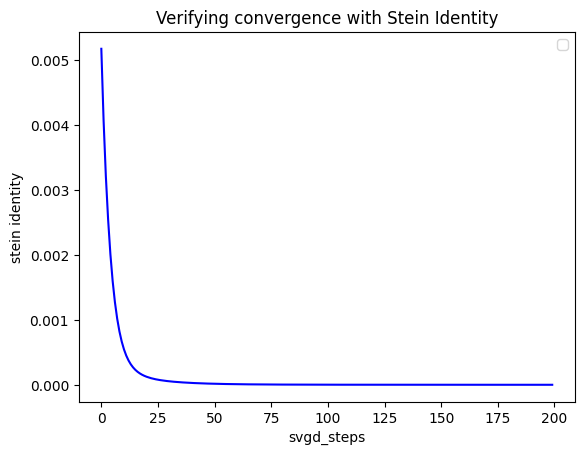

In [ ]:
stein_id_0 = pd.DataFrame({'svgd_step': np.arange(num_steps), 'stein identity': conv})
plt.plot(stein_id_0['svgd_step'], stein_id_0['stein identity'], color= '#0000FF')
plt.xlabel('svgd_steps')
plt.ylabel('stein identity')
plt.title('Verifying convergence with Stein Identity')
plt.legend()

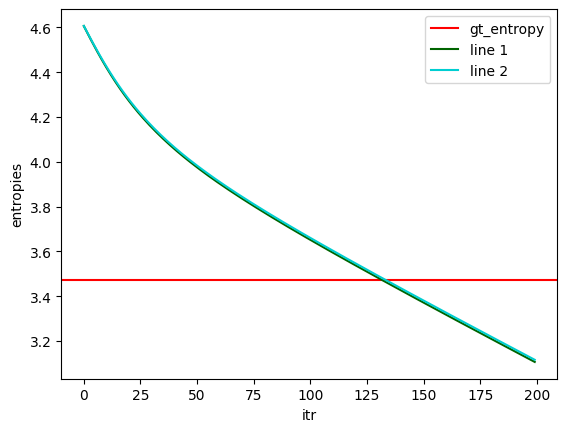

In [51]:
ent1 = [ent[i][0] for i in range(len(ent))]
ent2 = [ent[i][1] for i in range(len(ent))]

df = pd.DataFrame({'svgd_step':np.arange(num_steps), 'line1':ent1, 'line2':ent2})
## gt entropy
plt.axhline(y = gt_entr, color='r', linestyle='-', label = 'gt_entropy')
# line 1
plt.plot(df['svgd_step'], df['line1'], label = 'line 1', color = '#006400')
#line 2
plt.plot(df['svgd_step'], df['line2'], label = 'line 2', color = '#00CED1')
# add extra axis for the stein id
# plt.plot(stein_id_0['svgd_step'], stein_id_0['stein identity'], color= '#0000FF')
plt.legend()

plt.xlabel('itr')
plt.ylabel('entropies')

plt.show()

### Average number of Neighbors for particles when σ is set to 'forth'



> We track the number of neighbors in order <font color=FF7F50>evaluate the sensitivity of convergence to the σ at every step</font>



<font color=FF7F50>Every 10 steps observe the corresponding kernel $σ$ and the average number of particle neighbors</font>

In [ ]:
sigFORTH_neighbors = [sig[l][1] for l in range(0, num_steps, 10)]
sigFORTH_sigmas = [sig[l][0] for l in range(0, num_steps, 10)]

In [ ]:
sigMEAN_neighbors = [sig[l][1] for l in range(0, num_steps, 10)]
sigMEAN_sigmas = [sig[l][0] for l in range(0, num_steps, 10)]

In [ ]:
sigMEDIAN_neighbors = [sig[l][1] for l in range(0, num_steps, 10)]
sigMEDIAN_sigmas = [sig[l][0] for l in range(0, num_steps, 10)]

In [ ]:
sig5_neighbors = [sig[l][1] for l in range(0, num_steps, 10)]
sig5_sigmas = [sig[l][0] for l in range(0, num_steps, 10)]

<font color=FF7F50>Storing number of active particles for every kernel</font>

In [ ]:
active_particles_forth = act

In [ ]:
active_particles_mean = act

In [ ]:
active_particles_median = act

In [ ]:
len(active_particles_median[::10])

20

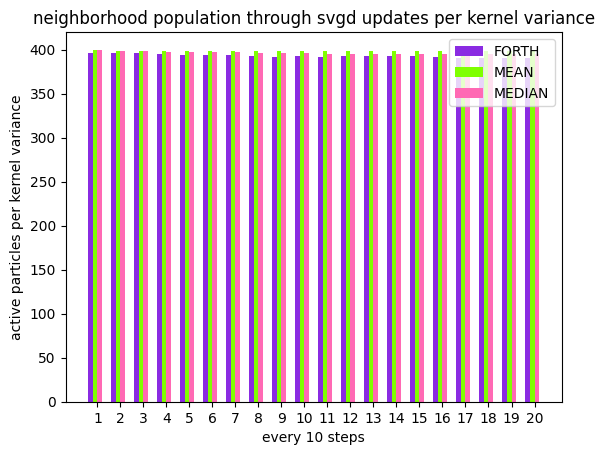

In [ ]:
#barring
a1 = active_particles_median[::10]
a2 = active_particles_forth[::10]
a3 = active_particles_mean[::10]
x = np.arange(len(a1))
width = 0.2

# Creating the plot
fig, ax = plt.subplots()
r1 = ax.bar(x - 1.5*width, a2, width, label='FORTH', color = '#8A2BE2')
r2 = ax.bar(x - 0.5*width, a3, width, label='MEAN', color = '#7FFF00')
r3 = ax.bar(x + 0.5*width, a1, width, label='MEDIAN', color = '#FF69B4')


# Add some text for labels, title, and custom x-axis tick labels
ax.set_xlabel('every 10 steps')
ax.set_ylabel('active particles per kernel variance')
ax.set_title('neighborhood population through svgd updates per kernel variance')
ax.set_xticks(x)
ax.set_xticklabels([str(i) for i in range(1, 21)])
ax.legend()

# Show the plot
plt.show()

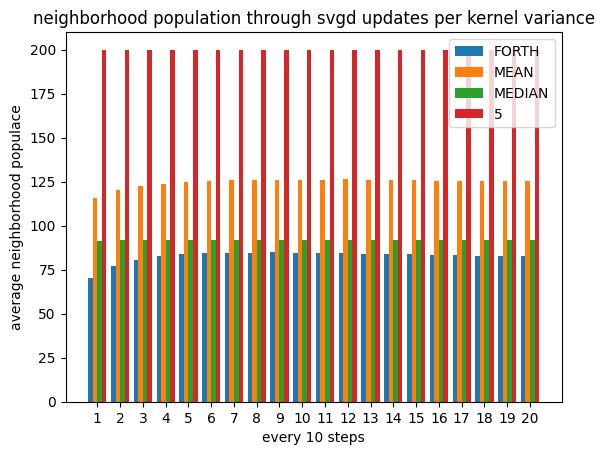

In [ ]:
#barring
a1 = active_particles_median[::10]
a2 = active_particles_median[::10]
a3 = active_particles_median[::10]
x = np.arange(len(a))
width = 0.2

# Creating the plot
fig, ax = plt.subplots()
r1 = ax.bar(x - 1.5*width, sigFORTH_neighbors, width, label='FORTH')
r2 = ax.bar(x - 0.5*width, sigMEAN_neighbors, width, label='MEAN')
r3 = ax.bar(x + 0.5*width, sigMEDIAN_neighbors, width, label='MEDIAN')
r4 = ax.bar(x + 1.5*width, sig5_neighbors, width, label='5')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_xlabel('every 10 steps')
ax.set_ylabel('average neighborhood populace')
ax.set_title('neighborhood population through svgd updates per kernel variance')
ax.set_xticks(x)
ax.set_xticklabels([str(i) for i in range(1, 21)])
ax.legend()

# Show the plot
plt.show()

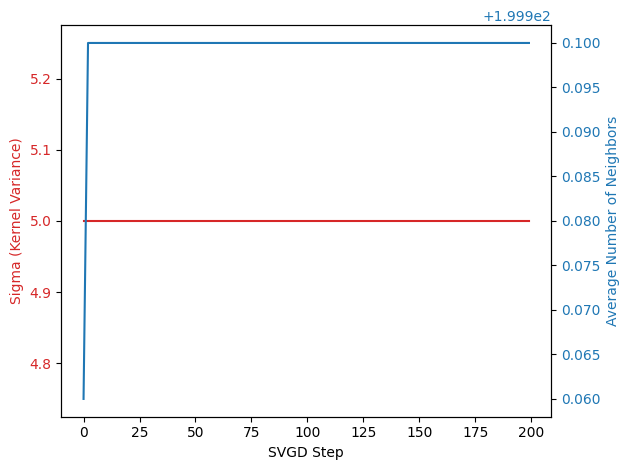

In [ ]:

# Extracting data
steps = list(sig.keys())
sigmas = [v[0] for v in sig.values()]
avg_neighbors = [v[1] for v in sig.values()]

# Creating the plot
fig, ax1 = plt.subplots()

# Plotting sigma values
color = 'tab:red'
ax1.set_xlabel('SVGD Step')
ax1.set_ylabel('Sigma (Kernel Variance)', color=color)
ax1.plot(steps, sigmas, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Instantiating a second y-axis for average number of neighbors
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Average Number of Neighbors', color=color)
ax2.plot(steps, avg_neighbors, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Showing the plot
fig.tight_layout()
plt.show()


#### Quantity of neighbors per particle for a kernel variance with invertibility 'proven' (σ = 5)



In [ ]:
sig

NameError: name 'sig' is not defined

In [ ]:
# Weather to use the GMM class or not (Figure 4a: gmm == False)
dist_type = 'gauss'
# Dimension of the particles
dim = 2
# Learning Rate
lr = 0.5
# Number of mixtures
n_gmm = 1
# Target distribution's standard deviation, means are computed automatically
gmm_std = 1
# Number of particles
num_particles = 200
# Number of update steps
num_steps = 200
# Kernel variance
kernel_variance = ['mean']
# Standard deviation of the initial distribution HMC
sigma_V_init = 5
# Dictionary used to select whare algorithms to run
run_alg = {'svgd':True, 'ld':False, 'dld':False, 'hmc':False}



# Mean of the initial distribution
mu_init = 0
# Standard deviation of the initial distribution
sigma_init = 6
# Do one experiment for initial distribution N(0, 6)
# sensitivity_to_para = c.defaultdict(list)
# for kernel_variance in kernel_variances:
#   for lr in lrs:
sampler_entr_svgd, charts_svgd, conv, ent, gt_entr, sigmas = my_experiment(dim, n_gmm, num_particles, num_steps, kernel_variance, gmm_std, lr, mu_init, sigma_init, sigma_V_init, dist_type, run_alg)
    # sensitivity_to_para[(lr, kernel_variance)] = [gt_entr, ent, conv]

# sampler_entr_svgd, sampler_entr_ld, sampler_entr_hmc, sampler_entr_dld, gt_entr, charts_svgd= my_experiment(dim, n_gmm, num_particles, num_steps, kernel_variance, gmm_std, lr, mu_init, sigma_init, sigma_V_init, dist_type, run_alg)
# print('##############################')

#________________________

# lr = 0.5
# # Number of update steps
# num_steps = [200, 20, 50]
# # Mean of the initial distribution
# mu_init = 4
# # Standard deviation of the initial distribution
# sigma_init = 0.2
# # Do one experiment for initial distribution N(4, 0.2)
# init_chart2, sampler_entr_svgd2, sampler_entr_ld2, sampler_entr_hmc2, sampler_entr_dld2, gt_entr2, charts_svgd2, charts_ld2, charts_hmc2, charts_dld2 = my_experiment(dim, n_gmm, num_particles, num_steps, kernel_variance, gmm_std, lr, mu_init, sigma_init, sigma_V_init, dist_type, run_alg)

# # Concatenate multiple plots together
# alt.vconcat(init_chart | charts_svgd[-1] | charts_dld[-1] | charts_ld[-1] | charts_hmc[-1], init_chart2 | charts_svgd2[-1] | charts_dld2[-1] | charts_ld2[-1] | charts_hmc2[-1])



TypeError: ignored

In [ ]:
import random

In [ ]:
pff = sensitivity_to_para[(0.1, 'median')][-1]

-> run experiment for

- $\sigma_{kernel}$ in `[0.1, 1, 3, 5, 7, 10, 100]`
- for $n_{particles}$ in `[200, 100, 20, 10]`

In [ ]:
#set the variables that remain unchanged
dist_type = 'gauss'
dim = 2
lr = 0.5
n_gmm = 1
gmm_std = 1
num_particles = [200, 100, 20, 10]
num_steps = [100, 20, 15]
kernel_variance = [0.1, 1, 3, 5, 7, 10, 100]
sigma_V_init = 5
run_alg = {'svgd':True, 'ld':False, 'dld':False, 'hmc':False}


mu_init = 0
sigma_init = 6



In [ ]:
particles_variance_map = {(n, v): 0 for n in num_particles for v in kernel_variance}

In [ ]:
init_chart, sampler_entr_svgd, charts_svgd = my_experiment(dim, n_gmm, n, num_steps, v, gmm_std, lr, mu_init, sigma_init, sigma_V_init, dist_type, run_alg)

In [ ]:
for pv in particles_variance_map:
    n, v = pv
    svgd = my_experiment(dim, n_gmm, n, num_steps, v, gmm_std, lr, mu_init, sigma_init, sigma_V_init, dist_type, run_alg)
    particles_variance_map[pv] = svgd

################# sampler_entr:  svgd 2.856290340423584
################# sampler_entr:  svgd 3.530557870864868
################# sampler_entr:  svgd 3.486802101135254
################# sampler_entr:  svgd 3.4669768810272217
################# sampler_entr:  svgd 3.5318825244903564
################# sampler_entr:  svgd 3.692735195159912
################# sampler_entr:  svgd 4.6287922859191895
################# sampler_entr:  svgd 2.216942071914673
################# sampler_entr:  svgd 3.0649642944335938
################# sampler_entr:  svgd 3.4880247116088867
################# sampler_entr:  svgd 3.5443897247314453
################# sampler_entr:  svgd 3.530729055404663
################# sampler_entr:  svgd 3.7633602619171143
################# sampler_entr:  svgd 4.5554070472717285
################# sampler_entr:  svgd -1.721961259841919
################# sampler_entr:  svgd 0.19078907370567322
################# sampler_entr:  svgd 3.0792882442474365
################# sampler_entr:  svg

In [ ]:
particles_variance_map

{(200, 0.1): 2.856290340423584,
 (200, 1): 3.530557870864868,
 (200, 3): 3.486802101135254,
 (200, 5): 3.4669768810272217,
 (200, 7): 3.5318825244903564,
 (200, 10): 3.692735195159912,
 (200, 100): 4.6287922859191895,
 (100, 0.1): 2.216942071914673,
 (100, 1): 3.0649642944335938,
 (100, 3): 3.4880247116088867,
 (100, 5): 3.5443897247314453,
 (100, 7): 3.530729055404663,
 (100, 10): 3.7633602619171143,
 (100, 100): 4.5554070472717285,
 (20, 0.1): -1.721961259841919,
 (20, 1): 0.19078907370567322,
 (20, 3): 3.0792882442474365,
 (20, 5): 3.4557945728302,
 (20, 7): 3.6190521717071533,
 (20, 10): 3.764420747756958,
 (20, 100): 4.7752814292907715,
 (10, 0.1): -11.71668815612793,
 (10, 1): -3.2220585346221924,
 (10, 3): 3.417800188064575,
 (10, 5): 3.29839825630188,
 (10, 7): 3.458068370819092,
 (10, 10): 3.6788482666015625,
 (10, 100): 4.370701313018799}

In [ ]:
import matplotlib.pyplot as plt

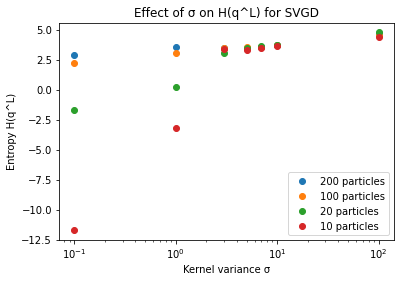

In [ ]:
for n in num_particles:
    entropies = [particles_variance_map[(n, v)] for v in kernel_variance]
    plt.scatter(kernel_variance, entropies, label=f'{n} particles')

plt.xlabel('Kernel variance σ')
plt.ylabel('Entropy H(q^L)')
plt.legend()
plt.title('Effect of σ on H(q^L) for SVGD')
plt.xscale('log')
plt.show()